In [20]:
from keras.datasets.mnist import load_data
from matplotlib import pyplot

(trainX, trainy), (testX, testy) = load_data()

print('Train', trainX.shape, trainy.shape)
print('Test', testX.shape, testy.shape)

Train (60000, 28, 28) (60000,)
Test (10000, 28, 28) (10000,)


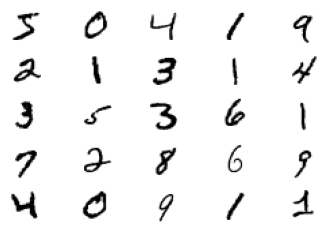

In [21]:
for i in range(25):
    pyplot.subplot(5, 5, 1+i)
    pyplot.axis('off')
    pyplot.imshow(trainX[i], cmap='gray_r')
pyplot.show()

In [22]:
from keras.models import Sequential
from keras.layers import Dense, Conv2D, Flatten, Dropout, LeakyReLU
from keras.optimizers import Adam
from keras.utils.vis_utils import plot_model
import numpy as np

def define_discriminator(in_shape=(28, 28, 1)):
    model = Sequential()
    model.add(Conv2D(64, (3,3), strides=(2, 2), padding='same', input_shape=in_shape))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Dropout(0.4))
    model.add(Conv2D(64, (3,3), strides=(2, 2), padding='same'))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Dropout(0.4))
    model.add(Flatten())
    model.add(Dense(1, activation='sigmoid'))
    # compile model
    opt = Adam(lr=0.0002, beta_1=0.5)
    model.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])
    return model

model = define_discriminator()
model.summary()
#plot_model(model, show_shapes=True, show_layer_names=True)

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_6 (Conv2D)            (None, 14, 14, 64)        640       
_________________________________________________________________
leaky_re_lu_10 (LeakyReLU)   (None, 14, 14, 64)        0         
_________________________________________________________________
dropout_4 (Dropout)          (None, 14, 14, 64)        0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 7, 7, 64)          36928     
_________________________________________________________________
leaky_re_lu_11 (LeakyReLU)   (None, 7, 7, 64)          0         
_________________________________________________________________
dropout_5 (Dropout)          (None, 7, 7, 64)          0         
_________________________________________________________________
flatten_2 (Flatten)          (None, 3136)             

In [23]:
def load_real_samples():
    (trainX, _), (_, _) = load_data()
    X = np.expand_dims(trainX, axis=-1)
    X = X.astype('float32')
    X = X/255.0
    return X

In [24]:
def generate_real_samples(dataset, n_samples):
    ix = np.random.randint(0, dataset.shape[0], n_samples)
    X = dataset[ix]
    y = np.ones((n_samples, 1))
    return X,y

def generate_fake_samples(n_samples):
    X = np.random.rand(28 * 28 * n_samples)
    X = X.reshape((n_samples, 28, 28, 1))
    y = np.zeros((n_samples, 1))
    return X,y

In [25]:
def train_discriminator(model, dataset, n_iter=100, n_batch=256):
    half_batch = int(n_batch/2)
    for i in range(n_iter):
        X_real, y_real = generate_real_samples(dataset, half_batch)
        _, real_acc = model.train_on_batch(X_real, y_real)
        X_fake, y_fake = generate_fake_samples(half_batch)
        _, fake_acc = model.train_on_batch(X_fake, y_fake)
        
        print('>%d real=%.0f%% fake=%.0f%%' % (i+1, real_acc*100, fake_acc*100))

In [26]:
dataset = load_real_samples()
train_discriminator(model, dataset)

>1 real=59% fake=39%
>2 real=61% fake=62%
>3 real=70% fake=79%
>4 real=59% fake=88%
>5 real=65% fake=97%
>6 real=63% fake=99%
>7 real=62% fake=100%
>8 real=67% fake=100%
>9 real=68% fake=100%
>10 real=72% fake=100%
>11 real=64% fake=100%
>12 real=65% fake=100%
>13 real=67% fake=100%
>14 real=70% fake=100%
>15 real=67% fake=100%
>16 real=69% fake=100%
>17 real=73% fake=100%
>18 real=80% fake=100%
>19 real=82% fake=100%
>20 real=88% fake=100%
>21 real=87% fake=100%
>22 real=88% fake=100%
>23 real=94% fake=100%
>24 real=86% fake=100%
>25 real=92% fake=100%
>26 real=93% fake=100%
>27 real=97% fake=100%
>28 real=97% fake=100%
>29 real=98% fake=100%
>30 real=98% fake=100%
>31 real=99% fake=100%
>32 real=100% fake=100%
>33 real=99% fake=100%
>34 real=100% fake=100%
>35 real=99% fake=100%
>36 real=100% fake=100%
>37 real=100% fake=100%
>38 real=100% fake=100%
>39 real=100% fake=100%
>40 real=99% fake=100%
>41 real=100% fake=100%
>42 real=100% fake=100%
>43 real=100% fake=100%
>44 real=100% fak

In [27]:
from keras.layers import Reshape
from keras.layers import Conv2DTranspose

def define_generator(latent_dim):
    model = Sequential()
    # foundation for 7x7 image
    n_nodes = 128 * 7 * 7
    model.add(Dense(n_nodes, input_dim=latent_dim))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Reshape((7, 7, 128)))
    # upsample to 14x14
    model.add(Conv2DTranspose(128, (4,4), strides=(2,2), padding='same'))
    model.add(LeakyReLU(alpha=0.2))
    # upsample to 28x28
    model.add(Conv2DTranspose(128, (4,4), strides=(2,2), padding='same'))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Conv2D(1, (7,7), activation='sigmoid', padding='same'))
    return model

latent_dim = 100
model = define_generator(latent_dim)
model.summary()

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_5 (Dense)              (None, 6272)              633472    
_________________________________________________________________
leaky_re_lu_12 (LeakyReLU)   (None, 6272)              0         
_________________________________________________________________
reshape_2 (Reshape)          (None, 7, 7, 128)         0         
_________________________________________________________________
conv2d_transpose_4 (Conv2DTr (None, 14, 14, 128)       262272    
_________________________________________________________________
leaky_re_lu_13 (LeakyReLU)   (None, 14, 14, 128)       0         
_________________________________________________________________
conv2d_transpose_5 (Conv2DTr (None, 28, 28, 128)       262272    
_________________________________________________________________
leaky_re_lu_14 (LeakyReLU)   (None, 28, 28, 128)      

In [28]:
def generate_latent_points(latent_dim, n_samples):
    x_input = np.random.randn(latent_dim * n_samples)
    x_input = x_input.reshape(n_samples, latent_dim)
    return x_input

In [29]:
def generate_fake_samples(g_model, latent_dim, n_samples):
    x_input = generate_latent_points(latent_dim, n_samples)
    X = g_model.predict(x_input)
    y = np.zeros((n_samples, 1))
    return X,y

(25, 28, 28, 1)


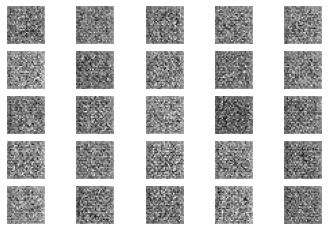

In [30]:
n_samples = 25
X, _ = generate_fake_samples(model, latent_dim, n_samples)
print(X.shape)
for i in range(n_samples):
    pyplot.subplot(5, 5, i+1)
    pyplot.axis('off')
    pyplot.imshow(X[i, : ,: , 0], cmap='gray_r')
pyplot.show()

In [31]:
def define_gan(g_model, d_model):
    d_model.trainable = False
    model = Sequential()
    model.add(g_model)
    model.add(d_model)
    opt = Adam(lr=0.0002, beta_1=0.5)
    model.compile(loss='binary_crossentropy', optimizer=opt)
    return model

d_model = define_discriminator()
g_model = define_generator(latent_dim)

gan_model = define_gan(g_model, d_model)
gan_model.summary()

Model: "sequential_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
sequential_8 (Sequential)    (None, 28, 28, 1)         1164289   
_________________________________________________________________
sequential_7 (Sequential)    (None, 1)                 40705     
Total params: 1,204,994
Trainable params: 1,164,289
Non-trainable params: 40,705
_________________________________________________________________


In [32]:
def train_gan(gan_model, latent_dim, n_epochs=100, n_batch=256):
    for i in range(n_epochs):
        x_gan = generate_latent_points(latent_dim, n_batch)
        y_gan = np.ones((n_batch, 1))
        gan_model.train_on_batch(x_gan, y_gan)

In [33]:
def train(g_model, d_model, gan_model, dataset, latent_dim, n_epochs=100, n_batch=256):
    bat_per_epo = int(dataset.shape[0] / n_batch)
    half_batch = int(n_batch / 2)
    
    for i in range(n_epochs):
        for j in range(bat_per_epo): # 234 batches
            X_real, y_real = generate_real_samples(dataset, half_batch)
            X_fake, y_fake = generate_fake_samples(g_model, latent_dim, half_batch)
            
            X, y = np.vstack((X_real, X_fake)), np.vstack((y_real, y_fake))
            d_loss, _ = d_model.train_on_batch(X, y)
            
            X_gan = generate_latent_points(latent_dim, n_batch)
            y_gan = np.ones((n_batch, 1))
            
            g_loss = gan_model.train_on_batch(X_gan, y_gan)
            print('>E:%d, %d/%d, d=%.3f, g=%.3f' % (i+1, j+1, bat_per_epo, d_loss, g_loss))
        if (i+1) % 10 == 0:
            summarize_performance(i, g_model, d_model, dataset, latent_dim)

In [34]:
def summarize_performance(epoch, g_model, d_model, dataset, latent_dim, n_samples=100):
    X_real, y_real = generate_real_samples(dataset, n_samples)
    _, acc_real = d_model.evaluate(X_real, y_real, verbose=0)
    x_fake, y_fake = generate_fake_samples(g_model, latent_dim, n_samples)
    _, acc_fake = d_model.evaluate(x_fake, y_fake, verbose=0)
    print('>Accuracy real: %.0f%%, fake: %.0f%%' % (acc_real*100, acc_fake*100))
    
    save_plot(x_fake, epoch)
    filename = 'generator_model_%03d.h5' % (epoch + 1)
    g_model.save(filename)

In [46]:
def save_plot(examples, epoch, n=10):
    # plot images
    for i in range(n * n):
        # define subplot
        pyplot.subplot(n, n, 1 + i)
        # turn off axis
        pyplot.axis('off')
        # plot raw pixel data
        pyplot.imshow(examples[i, :, :, 0], cmap='gray_r')
        # save plot to file
    pyplot.show()
    filename = 'generated_plot_e%03d.png' % (epoch+1)
    pyplot.savefig(filename)
    pyplot.close()

>E:1, 1/234, d=0.695, g=0.706
>E:1, 2/234, d=0.688, g=0.710
>E:1, 3/234, d=0.684, g=0.702
>E:1, 4/234, d=0.683, g=0.692
>E:1, 5/234, d=0.692, g=0.687
>E:1, 6/234, d=0.690, g=0.694
>E:1, 7/234, d=0.693, g=0.715
>E:1, 8/234, d=0.689, g=0.720
>E:1, 9/234, d=0.692, g=0.709
>E:1, 10/234, d=0.689, g=0.702
>E:1, 11/234, d=0.690, g=0.685
>E:1, 12/234, d=0.687, g=0.691
>E:1, 13/234, d=0.695, g=0.706
>E:1, 14/234, d=0.690, g=0.694
>E:1, 15/234, d=0.695, g=0.679
>E:1, 16/234, d=0.687, g=0.686
>E:1, 17/234, d=0.696, g=0.712
>E:1, 18/234, d=0.686, g=0.718
>E:1, 19/234, d=0.689, g=0.724
>E:1, 20/234, d=0.691, g=0.705
>E:1, 21/234, d=0.697, g=0.682
>E:1, 22/234, d=0.691, g=0.670
>E:1, 23/234, d=0.682, g=0.686
>E:1, 24/234, d=0.683, g=0.702
>E:1, 25/234, d=0.696, g=0.710
>E:1, 26/234, d=0.687, g=0.727
>E:1, 27/234, d=0.692, g=0.719
>E:1, 28/234, d=0.691, g=0.689
>E:1, 29/234, d=0.689, g=0.685
>E:1, 30/234, d=0.694, g=0.693
>E:1, 31/234, d=0.695, g=0.708
>E:1, 32/234, d=0.688, g=0.722
>E:1, 33/234, d=0

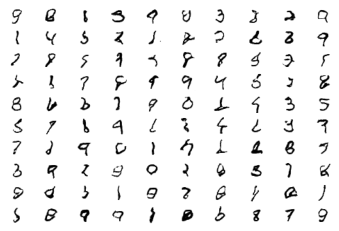

>E:11, 1/234, d=0.692, g=0.705
>E:11, 2/234, d=0.687, g=0.681
>E:11, 3/234, d=0.695, g=0.694
>E:11, 4/234, d=0.697, g=0.715
>E:11, 5/234, d=0.694, g=0.713
>E:11, 6/234, d=0.692, g=0.716
>E:11, 7/234, d=0.691, g=0.698
>E:11, 8/234, d=0.693, g=0.702
>E:11, 9/234, d=0.695, g=0.707
>E:11, 10/234, d=0.695, g=0.710
>E:11, 11/234, d=0.692, g=0.714
>E:11, 12/234, d=0.691, g=0.719
>E:11, 13/234, d=0.686, g=0.710
>E:11, 14/234, d=0.692, g=0.702
>E:11, 15/234, d=0.683, g=0.704
>E:11, 16/234, d=0.688, g=0.685
>E:11, 17/234, d=0.697, g=0.690
>E:11, 18/234, d=0.701, g=0.687
>E:11, 19/234, d=0.698, g=0.691
>E:11, 20/234, d=0.691, g=0.689
>E:11, 21/234, d=0.696, g=0.714
>E:11, 22/234, d=0.691, g=0.730
>E:11, 23/234, d=0.699, g=0.723
>E:11, 24/234, d=0.683, g=0.707
>E:11, 25/234, d=0.690, g=0.688
>E:11, 26/234, d=0.690, g=0.680
>E:11, 27/234, d=0.689, g=0.680
>E:11, 28/234, d=0.700, g=0.695
>E:11, 29/234, d=0.692, g=0.717
>E:11, 30/234, d=0.691, g=0.731
>E:11, 31/234, d=0.697, g=0.728
>E:11, 32/234, d=

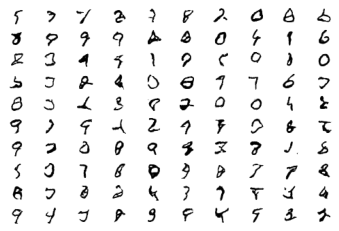

>E:21, 1/234, d=0.699, g=0.708
>E:21, 2/234, d=0.689, g=0.709
>E:21, 3/234, d=0.682, g=0.707
>E:21, 4/234, d=0.689, g=0.708
>E:21, 5/234, d=0.695, g=0.696
>E:21, 6/234, d=0.696, g=0.703
>E:21, 7/234, d=0.696, g=0.691
>E:21, 8/234, d=0.693, g=0.689
>E:21, 9/234, d=0.687, g=0.694
>E:21, 10/234, d=0.697, g=0.696
>E:21, 11/234, d=0.694, g=0.704
>E:21, 12/234, d=0.685, g=0.708
>E:21, 13/234, d=0.689, g=0.721
>E:21, 14/234, d=0.690, g=0.693
>E:21, 15/234, d=0.689, g=0.689
>E:21, 16/234, d=0.692, g=0.684
>E:21, 17/234, d=0.697, g=0.684
>E:21, 18/234, d=0.696, g=0.698
>E:21, 19/234, d=0.700, g=0.696
>E:21, 20/234, d=0.689, g=0.710
>E:21, 21/234, d=0.692, g=0.711
>E:21, 22/234, d=0.688, g=0.692
>E:21, 23/234, d=0.687, g=0.682
>E:21, 24/234, d=0.693, g=0.699
>E:21, 25/234, d=0.692, g=0.707
>E:21, 26/234, d=0.691, g=0.694
>E:21, 27/234, d=0.695, g=0.697
>E:21, 28/234, d=0.692, g=0.693
>E:21, 29/234, d=0.695, g=0.711
>E:21, 30/234, d=0.688, g=0.718
>E:21, 31/234, d=0.689, g=0.709
>E:21, 32/234, d=

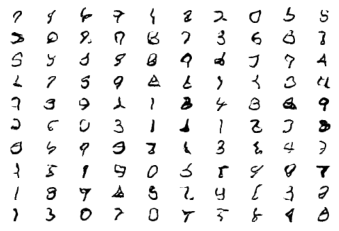

>E:31, 1/234, d=0.699, g=0.696
>E:31, 2/234, d=0.695, g=0.705
>E:31, 3/234, d=0.692, g=0.709
>E:31, 4/234, d=0.694, g=0.694
>E:31, 5/234, d=0.686, g=0.693
>E:31, 6/234, d=0.693, g=0.694
>E:31, 7/234, d=0.698, g=0.707
>E:31, 8/234, d=0.694, g=0.708
>E:31, 9/234, d=0.688, g=0.705
>E:31, 10/234, d=0.696, g=0.694
>E:31, 11/234, d=0.694, g=0.679
>E:31, 12/234, d=0.687, g=0.667
>E:31, 13/234, d=0.692, g=0.680
>E:31, 14/234, d=0.685, g=0.705
>E:31, 15/234, d=0.685, g=0.724
>E:31, 16/234, d=0.695, g=0.713
>E:31, 17/234, d=0.700, g=0.701
>E:31, 18/234, d=0.700, g=0.685
>E:31, 19/234, d=0.683, g=0.685
>E:31, 20/234, d=0.693, g=0.706
>E:31, 21/234, d=0.694, g=0.705
>E:31, 22/234, d=0.694, g=0.704
>E:31, 23/234, d=0.688, g=0.694
>E:31, 24/234, d=0.691, g=0.694
>E:31, 25/234, d=0.691, g=0.696
>E:31, 26/234, d=0.695, g=0.705
>E:31, 27/234, d=0.695, g=0.709
>E:31, 28/234, d=0.689, g=0.713
>E:31, 29/234, d=0.689, g=0.690
>E:31, 30/234, d=0.687, g=0.697
>E:31, 31/234, d=0.695, g=0.692
>E:31, 32/234, d=

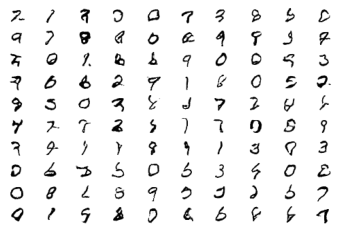

>E:41, 1/234, d=0.700, g=0.679
>E:41, 2/234, d=0.692, g=0.698
>E:41, 3/234, d=0.691, g=0.696
>E:41, 4/234, d=0.692, g=0.705
>E:41, 5/234, d=0.691, g=0.698
>E:41, 6/234, d=0.696, g=0.698
>E:41, 7/234, d=0.698, g=0.692
>E:41, 8/234, d=0.692, g=0.696
>E:41, 9/234, d=0.691, g=0.716
>E:41, 10/234, d=0.689, g=0.732
>E:41, 11/234, d=0.691, g=0.710
>E:41, 12/234, d=0.690, g=0.695
>E:41, 13/234, d=0.688, g=0.685
>E:41, 14/234, d=0.696, g=0.689
>E:41, 15/234, d=0.690, g=0.690
>E:41, 16/234, d=0.697, g=0.683
>E:41, 17/234, d=0.695, g=0.690
>E:41, 18/234, d=0.690, g=0.699
>E:41, 19/234, d=0.697, g=0.700
>E:41, 20/234, d=0.691, g=0.699
>E:41, 21/234, d=0.699, g=0.689
>E:41, 22/234, d=0.689, g=0.696
>E:41, 23/234, d=0.688, g=0.698
>E:41, 24/234, d=0.692, g=0.691
>E:41, 25/234, d=0.689, g=0.703
>E:41, 26/234, d=0.690, g=0.704
>E:41, 27/234, d=0.689, g=0.710
>E:41, 28/234, d=0.690, g=0.702
>E:41, 29/234, d=0.694, g=0.703
>E:41, 30/234, d=0.693, g=0.708
>E:41, 31/234, d=0.692, g=0.706
>E:41, 32/234, d=

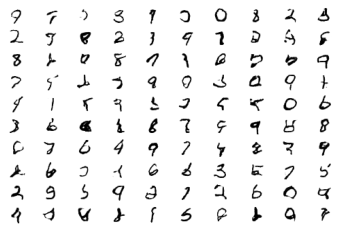

>E:51, 1/234, d=0.700, g=0.699
>E:51, 2/234, d=0.694, g=0.709
>E:51, 3/234, d=0.693, g=0.687
>E:51, 4/234, d=0.692, g=0.687
>E:51, 5/234, d=0.689, g=0.689
>E:51, 6/234, d=0.692, g=0.696
>E:51, 7/234, d=0.692, g=0.701
>E:51, 8/234, d=0.693, g=0.712
>E:51, 9/234, d=0.687, g=0.706
>E:51, 10/234, d=0.694, g=0.709
>E:51, 11/234, d=0.686, g=0.710
>E:51, 12/234, d=0.694, g=0.709
>E:51, 13/234, d=0.691, g=0.700
>E:51, 14/234, d=0.688, g=0.698
>E:51, 15/234, d=0.694, g=0.700
>E:51, 16/234, d=0.695, g=0.706
>E:51, 17/234, d=0.687, g=0.697
>E:51, 18/234, d=0.693, g=0.699
>E:51, 19/234, d=0.693, g=0.690
>E:51, 20/234, d=0.688, g=0.690
>E:51, 21/234, d=0.689, g=0.699
>E:51, 22/234, d=0.696, g=0.694
>E:51, 23/234, d=0.696, g=0.700
>E:51, 24/234, d=0.691, g=0.695
>E:51, 25/234, d=0.692, g=0.690
>E:51, 26/234, d=0.688, g=0.689
>E:51, 27/234, d=0.693, g=0.694
>E:51, 28/234, d=0.692, g=0.708
>E:51, 29/234, d=0.688, g=0.713
>E:51, 30/234, d=0.691, g=0.712
>E:51, 31/234, d=0.692, g=0.694
>E:51, 32/234, d=

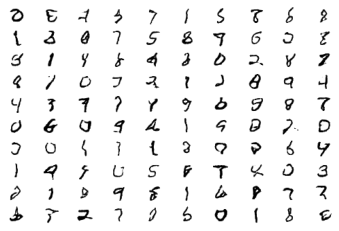

>E:61, 1/234, d=0.695, g=0.713
>E:61, 2/234, d=0.692, g=0.709
>E:61, 3/234, d=0.694, g=0.693
>E:61, 4/234, d=0.692, g=0.679
>E:61, 5/234, d=0.692, g=0.673
>E:61, 6/234, d=0.690, g=0.692
>E:61, 7/234, d=0.697, g=0.702
>E:61, 8/234, d=0.688, g=0.712
>E:61, 9/234, d=0.692, g=0.709
>E:61, 10/234, d=0.690, g=0.693
>E:61, 11/234, d=0.692, g=0.689
>E:61, 12/234, d=0.690, g=0.695
>E:61, 13/234, d=0.693, g=0.702
>E:61, 14/234, d=0.689, g=0.685
>E:61, 15/234, d=0.691, g=0.680
>E:61, 16/234, d=0.692, g=0.696
>E:61, 17/234, d=0.688, g=0.698
>E:61, 18/234, d=0.698, g=0.704
>E:61, 19/234, d=0.694, g=0.698
>E:61, 20/234, d=0.691, g=0.696
>E:61, 21/234, d=0.692, g=0.686
>E:61, 22/234, d=0.694, g=0.696
>E:61, 23/234, d=0.694, g=0.711
>E:61, 24/234, d=0.693, g=0.708
>E:61, 25/234, d=0.692, g=0.701
>E:61, 26/234, d=0.694, g=0.701
>E:61, 27/234, d=0.695, g=0.691
>E:61, 28/234, d=0.696, g=0.690
>E:61, 29/234, d=0.687, g=0.695
>E:61, 30/234, d=0.692, g=0.694
>E:61, 31/234, d=0.693, g=0.694
>E:61, 32/234, d=

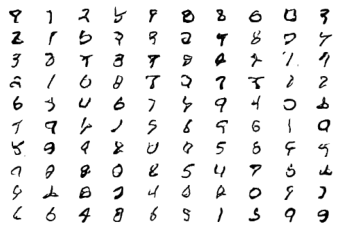

>E:71, 1/234, d=0.686, g=0.709
>E:71, 2/234, d=0.698, g=0.695
>E:71, 3/234, d=0.692, g=0.684
>E:71, 4/234, d=0.691, g=0.685
>E:71, 5/234, d=0.695, g=0.685
>E:71, 6/234, d=0.701, g=0.690
>E:71, 7/234, d=0.696, g=0.694
>E:71, 8/234, d=0.690, g=0.706
>E:71, 9/234, d=0.693, g=0.700
>E:71, 10/234, d=0.690, g=0.693
>E:71, 11/234, d=0.693, g=0.682
>E:71, 12/234, d=0.696, g=0.687
>E:71, 13/234, d=0.696, g=0.696
>E:71, 14/234, d=0.696, g=0.699
>E:71, 15/234, d=0.694, g=0.697
>E:71, 16/234, d=0.699, g=0.700
>E:71, 17/234, d=0.696, g=0.699
>E:71, 18/234, d=0.690, g=0.704
>E:71, 19/234, d=0.689, g=0.703
>E:71, 20/234, d=0.695, g=0.701
>E:71, 21/234, d=0.695, g=0.694
>E:71, 22/234, d=0.694, g=0.687
>E:71, 23/234, d=0.692, g=0.697
>E:71, 24/234, d=0.696, g=0.694
>E:71, 25/234, d=0.693, g=0.703
>E:71, 26/234, d=0.697, g=0.700
>E:71, 27/234, d=0.689, g=0.708
>E:71, 28/234, d=0.692, g=0.697
>E:71, 29/234, d=0.696, g=0.688
>E:71, 30/234, d=0.691, g=0.678
>E:71, 31/234, d=0.691, g=0.688
>E:71, 32/234, d=

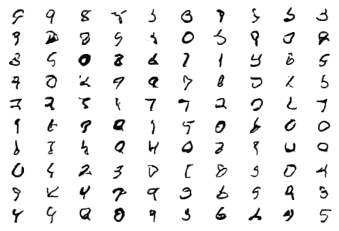

>E:81, 1/234, d=0.704, g=0.689
>E:81, 2/234, d=0.693, g=0.702
>E:81, 3/234, d=0.695, g=0.699
>E:81, 4/234, d=0.694, g=0.684
>E:81, 5/234, d=0.687, g=0.694
>E:81, 6/234, d=0.697, g=0.691
>E:81, 7/234, d=0.693, g=0.702
>E:81, 8/234, d=0.688, g=0.708
>E:81, 9/234, d=0.694, g=0.704
>E:81, 10/234, d=0.692, g=0.686
>E:81, 11/234, d=0.695, g=0.675
>E:81, 12/234, d=0.693, g=0.684
>E:81, 13/234, d=0.696, g=0.715
>E:81, 14/234, d=0.691, g=0.714
>E:81, 15/234, d=0.690, g=0.703
>E:81, 16/234, d=0.690, g=0.690
>E:81, 17/234, d=0.694, g=0.684
>E:81, 18/234, d=0.692, g=0.695
>E:81, 19/234, d=0.689, g=0.704
>E:81, 20/234, d=0.692, g=0.708
>E:81, 21/234, d=0.689, g=0.694
>E:81, 22/234, d=0.695, g=0.682
>E:81, 23/234, d=0.697, g=0.682
>E:81, 24/234, d=0.698, g=0.686
>E:81, 25/234, d=0.695, g=0.695
>E:81, 26/234, d=0.691, g=0.701
>E:81, 27/234, d=0.690, g=0.709
>E:81, 28/234, d=0.694, g=0.711
>E:81, 29/234, d=0.691, g=0.709
>E:81, 30/234, d=0.695, g=0.698
>E:81, 31/234, d=0.693, g=0.689
>E:81, 32/234, d=

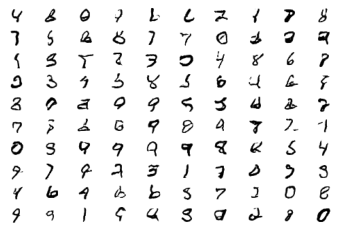

>E:91, 1/234, d=0.692, g=0.697
>E:91, 2/234, d=0.690, g=0.687
>E:91, 3/234, d=0.693, g=0.693
>E:91, 4/234, d=0.696, g=0.706
>E:91, 5/234, d=0.694, g=0.715
>E:91, 6/234, d=0.695, g=0.726
>E:91, 7/234, d=0.693, g=0.705
>E:91, 8/234, d=0.692, g=0.691
>E:91, 9/234, d=0.693, g=0.689
>E:91, 10/234, d=0.690, g=0.683
>E:91, 11/234, d=0.687, g=0.684
>E:91, 12/234, d=0.695, g=0.681
>E:91, 13/234, d=0.693, g=0.676
>E:91, 14/234, d=0.692, g=0.687
>E:91, 15/234, d=0.698, g=0.707
>E:91, 16/234, d=0.695, g=0.711
>E:91, 17/234, d=0.695, g=0.704
>E:91, 18/234, d=0.695, g=0.695
>E:91, 19/234, d=0.696, g=0.697
>E:91, 20/234, d=0.696, g=0.702
>E:91, 21/234, d=0.697, g=0.713
>E:91, 22/234, d=0.691, g=0.705
>E:91, 23/234, d=0.695, g=0.702
>E:91, 24/234, d=0.694, g=0.694
>E:91, 25/234, d=0.693, g=0.688
>E:91, 26/234, d=0.691, g=0.696
>E:91, 27/234, d=0.695, g=0.699
>E:91, 28/234, d=0.691, g=0.691
>E:91, 29/234, d=0.700, g=0.686
>E:91, 30/234, d=0.692, g=0.680
>E:91, 31/234, d=0.691, g=0.686
>E:91, 32/234, d=

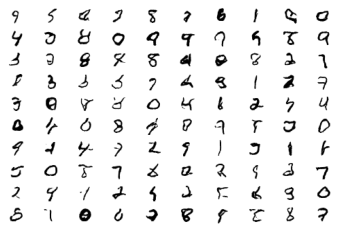

In [47]:
train(g_model, d_model, gan_model, dataset, latent_dim)